## In this notebook, we will
1. Import reduction potential data for over 5000 molecules
2. Perform data cleaning operations (correlated feature elimination and p-value hypothesis testing) using customised classes and methods.
3. Split data into 80-20 training and testing tests and save as .csv files for training ML models in the following notebooks

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random 
import os

from Functions import ChemClean
from Functions import Descriptors

In [4]:
import rdkit.Chem as Chem
from rdkit.Chem import rdMolDescriptors 

In [5]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import shuffle

import statsmodels.api as sm

## Load data from url

In [6]:
url='https://raw.githubusercontent.com/akashjn/DataScience/main/Data/BTZ_5442mols_smiles_redpot.csv'
data=pd.read_csv(url)
data=data.sample(frac=1)
data.index=range(data.shape[0])
data.head()

,SMILES,ERed
0,Cc1c2c(c(N(C)C(C)C)c3nsnc13)OCC(C)O2,1.37
1,CCCc1ccc2nsnc2c1N(C)CC,1.57
2,CCCN1CN(C)c2c1cc1nsnc1c2/[NH+]=C(/[O-])C(C)C,1.21
3,CCC(C)Nc1c(NC(C)C)c(NC)c2nsnc2c1C,1.35
4,COc1c2c(c(OC)c3nsnc13)N(C)CCN2C,1.46


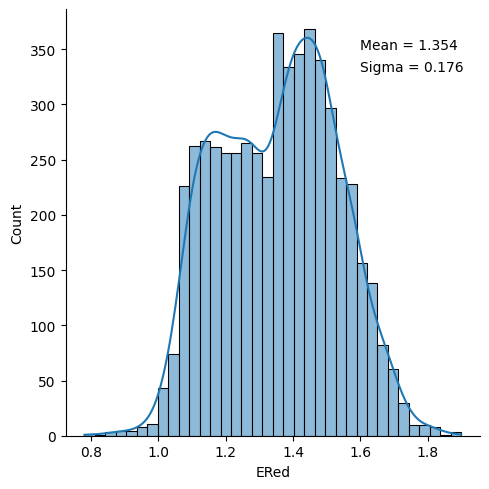

In [7]:
ax=sns.displot(data, x="ERed",kde=True)
plt.text(1.6,350,'Mean = '+str(np.round(np.mean(data['ERed']),3)))
plt.text(1.6,330,'Sigma = '+str(np.round(np.std(data['ERed']),3)))
plt.show()

## Generate descriptors using Descriptors.py

In [8]:
%%time
p=Descriptors.desc(data['SMILES'])
df_rdkit=p.RDkit_descriptors()
print(df_rdkit.shape)
df_rdkit.head()

(5442, 208)
CPU times: total: 1min 3s
Wall time: 1min 3s


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,5.995808,0.057825,5.995808,0.057825,0.851555,293.392,274.240,293.119798,108,0,...,0,0,0,0,0,0,0,0,0,0
1,4.419482,0.993407,4.419482,0.993407,0.815096,235.356,218.220,235.114319,86,0,...,0,0,0,0,0,0,0,0,0,0
2,12.203540,-0.073190,12.203540,0.004668,0.654150,319.434,298.266,319.146681,118,0,...,0,0,0,0,0,0,0,0,0,0
3,4.463668,0.345396,4.463668,0.345396,0.750608,307.467,282.267,307.183067,116,0,...,0,0,0,0,0,0,0,0,0,0
4,5.582742,0.768750,5.582742,0.768750,0.832515,280.353,264.225,280.099397,102,0,...,0,0,0,0,0,0,0,0,0,0


## Data cleaning operations from ChemClean.py

In [9]:
p=ChemClean.clean(df_rdkit)

In [10]:
p.remove_nan().head()
p.remove_unique().head()
p.remove_columns_low_std(0.1).head()
df_model=p.remove_corr_features(0.7)

# VERIFY HOW FEATURES ARE REMOVED AFTER CHECKING FOR CORRELATION


print(df_model.shape)
df_model.head()

Removing 0 columns with nan, if any
Before: df.shape=(5442, 208)
After: df.shape=(5442, 208) 

removing 84 columns values with a unique value
Before: df.shape=(5442, 208)
After: df.shape=(5442, 124) 

Removed 10 columns with std < 0.1 
Dropped 75 features with correlation coeff. > 0.70
(5442, 39)


,MaxEStateIndex,MinEStateIndex,MolWt,FpDensityMorgan1,BCUT2D_MWLOW,BCUT2D_LOGPLOW,BalabanJ,HallKierAlpha,PEOE_VSA10,PEOE_VSA11,...,VSA_EState2,VSA_EState8,VSA_EState9,NHOHCount,NumAliphaticHeterocycles,fr_ArN,fr_Ndealkylation1,fr_aryl_methyl,fr_bicyclic,fr_unbrch_alkane
0,5.995808,0.057825,293.392,1.250000,10.079376,-2.305378,2.314574,-1.56,29.431636,11.499024,...,2.168009,8.878626,2.051383,0,1,0,0,1,2,0
1,4.419482,0.993407,235.356,1.250000,10.057398,-2.176648,2.600152,-1.16,11.033401,0.000000,...,2.258657,5.362034,2.118333,0,0,0,0,1,1,0
2,12.203540,-0.073190,319.434,1.454545,10.141894,-2.718543,2.236264,-1.89,17.101832,5.516701,...,7.545804,7.758233,2.046780,1,1,0,0,0,2,0
3,4.463668,0.345396,307.467,1.000000,10.055042,-2.191696,2.680323,-1.56,11.033401,0.000000,...,0.000000,10.779344,1.932529,3,0,0,0,1,1,0
4,5.582742,0.768750,280.353,0.894737,10.098681,-2.369640,2.445573,-1.76,11.374773,22.532425,...,4.352130,1.873188,7.449892,0,1,0,2,0,2,0


In [31]:
# target=data['ERed']
target=data
features=df_model.copy()
features.shape
features.head()

,MaxEStateIndex,MinEStateIndex,MolWt,FpDensityMorgan1,BCUT2D_MWLOW,BCUT2D_LOGPLOW,BalabanJ,HallKierAlpha,PEOE_VSA10,PEOE_VSA11,...,VSA_EState2,VSA_EState8,VSA_EState9,NHOHCount,NumAliphaticHeterocycles,fr_ArN,fr_Ndealkylation1,fr_aryl_methyl,fr_bicyclic,fr_unbrch_alkane
0,5.995808,0.057825,293.392,1.250000,10.079376,-2.305378,2.314574,-1.56,29.431636,11.499024,...,2.168009,8.878626,2.051383,0,1,0,0,1,2,0
1,4.419482,0.993407,235.356,1.250000,10.057398,-2.176648,2.600152,-1.16,11.033401,0.000000,...,2.258657,5.362034,2.118333,0,0,0,0,1,1,0
2,12.203540,-0.073190,319.434,1.454545,10.141894,-2.718543,2.236264,-1.89,17.101832,5.516701,...,7.545804,7.758233,2.046780,1,1,0,0,0,2,0
3,4.463668,0.345396,307.467,1.000000,10.055042,-2.191696,2.680323,-1.56,11.033401,0.000000,...,0.000000,10.779344,1.932529,3,0,0,0,1,1,0
4,5.582742,0.768750,280.353,0.894737,10.098681,-2.369640,2.445573,-1.76,11.374773,22.532425,...,4.352130,1.873188,7.449892,0,1,0,2,0,2,0


#### ********************************************************************************************************************************************************************

### <span style="color:red">For convenience, the previous feature engineering operations are packaged in a single python file, with unit tests implemented to check for correctness.</span>

### UnitTesting/FeaturesTest.py contains a function called feature_reduction() which combines the prevous feature engineering operations

### UnitTesting/FeaturesTest.py contains a class called TestFeatureEngineering which implements the unit test.

In [32]:
from UnitTesting import FeaturesTest

feature_size_after_reduction=FeaturesTest.feature_reduction(df_rdkit)
feature_size_after_reduction

Removing 0 columns with nan, if any
Before: df.shape=(5442, 208)
After: df.shape=(5442, 208) 

removing 84 columns values with a unique value
Before: df.shape=(5442, 208)
After: df.shape=(5442, 124) 

Removed 10 columns with std < 0.1 
Dropped 75 features with correlation coeff. > 0.70


(5442, 39)

### <span style="color:red">Unit Testing is successful</span>

In [33]:
current=os.getcwd()

os.chdir(os.path.expanduser('UnitTesting'))

!python3.10 -m unittest FeaturesTest.py

os.chdir(os.path.expanduser(current))

Removing 0 columns with nan, if any
Before: df.shape=(5442, 208)
After: df.shape=(5442, 208) 

removing 84 columns values with a unique value
Before: df.shape=(5442, 208)
After: df.shape=(5442, 124) 

Removed 10 columns with std < 0.1 
Dropped 75 features with correlation coeff. > 0.70


.
----------------------------------------------------------------------
Ran 1 test in 0.487s

OK


#### ********************************************************************************************************************************************************************

## Feature elimination using p-value test; using Linear Regression

### p-values calculated using ordinary least squares fit

In [35]:
mod = sm.OLS(target['ERed'],features)
fii = mod.fit()
fii.summary2().tables[1].head()

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
MaxEStateIndex,0.032146,0.002572,12.498263,2.343020e-35,0.027104,0.037188
MinEStateIndex,0.024024,0.008888,2.702920,6.894821e-03,0.006600,0.041449
MolWt,-0.006181,0.000579,-10.669231,2.587961e-26,-0.007317,-0.005045
FpDensityMorgan1,0.040480,0.011253,3.597217,3.245165e-04,0.018419,0.062540
BCUT2D_MWLOW,0.019360,0.011387,1.700172,8.915612e-02,-0.002963,0.041683


### Recursive elimination of all features whose p-value < alpha (=0.02)

In [37]:
alpha=0.02
for a in range(len(features.columns)):
    mod = sm.OLS(target['ERed'],features)
    fii = mod.fit()
    p_values = fii.summary2().tables[1]['P>|t|']
    cols=[]
    for i in range(len(p_values)):
        if p_values[i]>alpha:
            cols.append(p_values.index[i])
    if len(cols)==0:
        break
    print(len(cols),'descriptors eliminated in iteration',str(a+1))
    features.drop(columns=cols,inplace=True)
    
print('Final model has',features.shape,'desriptors')
columns=features.columns
columns

5 descriptors eliminated in iteration 1
1 descriptors eliminated in iteration 2
1 descriptors eliminated in iteration 3
Final model has (5442, 32) desriptors


Index(['MaxEStateIndex', 'MolWt', 'FpDensityMorgan1', 'BCUT2D_LOGPLOW',
       'BalabanJ', 'HallKierAlpha', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12',
       'PEOE_VSA2', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9',
       'SMR_VSA10', 'SMR_VSA4', 'SMR_VSA5', 'SlogP_VSA3', 'SlogP_VSA4',
       'SlogP_VSA6', 'EState_VSA4', 'EState_VSA6', 'EState_VSA7',
       'EState_VSA8', 'VSA_EState2', 'VSA_EState9', 'NHOHCount',
       'NumAliphaticHeterocycles', 'fr_ArN', 'fr_Ndealkylation1',
       'fr_bicyclic', 'fr_unbrch_alkane'],
      dtype='object')

## Split into 80-20 training and testing sets and save to csv files

In [38]:
features_train,features_test,target_train,target_test=train_test_split(features,target,test_size=0.2,random_state=42)

In [39]:
features_train.index=range(features_train.shape[0])
features_train.to_csv('Data/features_train.csv')
features_test.index=range(features_test.shape[0])
features_test.to_csv('Data/features_test.csv')
target_train.index=range(target_train.shape[0])
target_train.to_csv('Data/target_train.csv')
target_test.index=range(target_test.shape[0])
target_test.to_csv('Data/target_test.csv')

In [40]:
print('Training set contains',target_train.shape[0],'entries')
print('Testing set contains',target_test.shape[0],'entries')

Training set contains 4353 entries
Testing set contains 1089 entries


## Scale the features and save to csv files

In [41]:
scaler=StandardScaler()

In [42]:
features_train=scaler.fit_transform(features_train)
features_test=scaler.transform(features_test)

In [43]:
features_train=pd.DataFrame(features_train,columns=columns)
features_train.to_csv('Data/features_train_scaled.csv',index=False)
features_test=pd.DataFrame(features_test,columns=columns)
features_test.to_csv('Data/features_test_scaled.csv',index=False)

### Visualise distribution of reduction potentials in the training and testing datasets

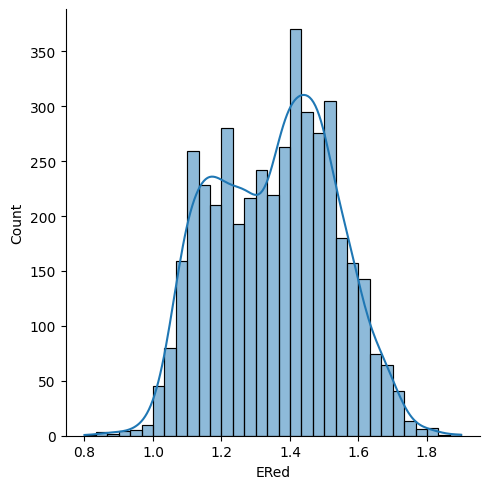

In [50]:
Ered_train=pd.read_csv('Data/target_train.csv',index_col=0)
ax=sns.displot(Ered_train,x='ERed',kde=True)
plt.show()

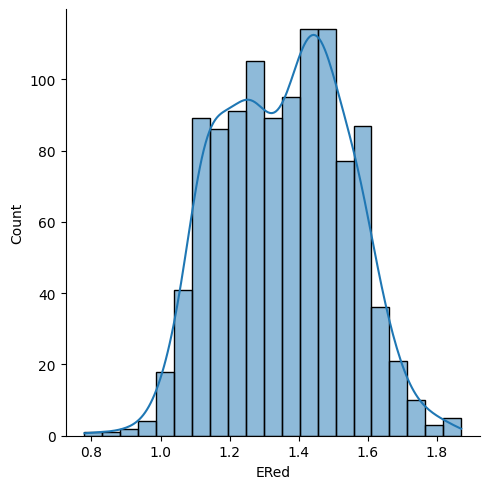

In [51]:
Ered_test=pd.read_csv('Data/target_test.csv',index_col=0)
ax=sns.displot(Ered_test,x='ERed',kde=True)
plt.show()

In the next notebook, <font color = blue>2.MolRedPot_Regression.ipynb
</font>, we will develop cross-validated simple linear and ensemble regression models to predict the reduction potential of these molecules.